In [11]:
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import log_loss 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.simplefilter(action='ignore')

In [2]:
test = pd.read_csv('test_label_enc.csv')
train = pd.read_csv('train_label_enc.csv')

In [3]:
# Aca saco las columnas que no quiero que las tome mi algoritmo.
features = list(set(train.columns) - set(['ID','Stage','Sales_Contract_No','contrato','Opportunity_ID','Opportunity_Created_Date','Account_Created_Date','Opportunity_Name',\
                                        'Price', 'Currency', 'ASP', 'ASP_converted_Currency', 'ASP_(converted)',\
                                        'Planned_Delivery_Start_Date','Size', 'Planned_Delivery_End_Date', 'Month',\
                                         'Delivery_Year', 'Actual_Delivery_Date','Product_Type','Product_Category_B',\
                                        'Total_Amount_Currency', 'Total_Amount','Last_Activity',\
                                        'Quote_Expiry_Date', 'Last_Modified_Date',\
                                        'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount','Account_Created_Date'\
                                          ,'Total_moneda_local','ASP_Currency','Last_Modified_By','Brand','Bureaucratic_Code',\
                                         'tiempo_creacion_ulti_mod','ASP_converted','Product_Name','Opportunity_Owner',\
                                          'Account_Owner','Product_Family','Account_Name']))
#features

In [4]:
train_pos= train.loc[train['Stage']==1,:].sample(7315)
train_neg = train.loc[train['Stage']==0,:].sample(7315)
train=pd.concat([train_pos,train_neg]).drop_duplicates(keep=False)
train= shuffle(train)

In [5]:
X = train[features]
Y = train['Stage']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [6]:
gbm = LGBMClassifier()
gbm.fit(x_train[features], y_train)

LGBMClassifier()

In [7]:
x_test['prediccion']=gbm.predict_proba(x_test[features])[:,1]
x_test['real'] = y_test

In [8]:
log_loss( x_test['real'].astype('float'),x_test['prediccion'].astype('float'))

0.21246503093361635

In [80]:
def mi_log_loss(model):
    rmse= (-cross_val_score(model, x_train, y_train, scoring= 'neg_log_loss', cv = 3))
    return(rmse)

### Ensamble solamente con BaggingClassifier como modelo

In [447]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [100, 200, 300, 400]
cv_rmse_br = [mi_log_loss(BaggingClassifier(n_estimators = n_estimator)).mean() 
            for n_estimator in n_estimators]

In [448]:
print (cv_rmse_br)

[0.4087965475313204, 0.37307931581264797, 0.37404308001634573, 0.37678595717893865]


Text(0, 0.5, 'log_loss')

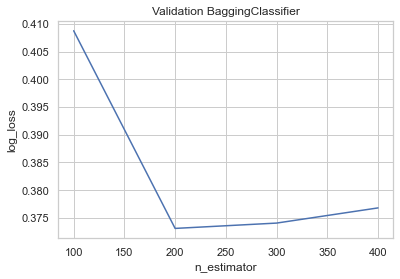

In [449]:
cv_br = pd.Series(cv_rmse_br , index = n_estimators)
cv_br.plot(title = "Validation BaggingClassifier")
plt.xlabel("n_estimator")
plt.ylabel("log_loss")

In [464]:
clf = BaggingClassifier(n_estimators=200).fit(X, Y)
x_test['prediccion']=clf.predict_proba(x_test[features])[:,1]

In [ ]:
log_loss( x_test['real'].astype('float'),x_test['prediccion'].astype('float'))

In [466]:
pred = clf.predict_proba(test[features])[:,1]

In [467]:
test['target']=pred

In [537]:
test[['Opportunity_ID', 'target']].to_csv("subidas/Bagging_solo_200_estimadores.csv", index=False)

#### Ensamble Bagging utilizando LGBMClassifier

In [ ]:
n_estimators = [100, 200, 300, 400]
cv_rmse_br = [mi_log_loss(BaggingClassifier(LGBMClassifier(),n_estimators = n_estimator)).mean() 
            for n_estimator in n_estimators]

Text(0, 0.5, 'log_loss')

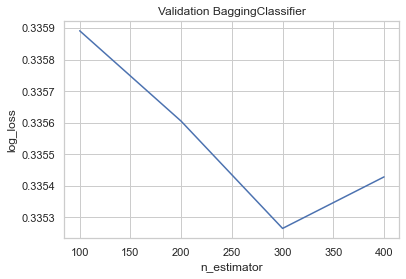

In [463]:
cv_br = pd.Series(cv_rmse_br , index = n_estimators)
cv_br.plot(title = "Validation BaggingClassifier")
plt.xlabel("n_estimator")
plt.ylabel("log_loss")

In [12]:
clf = BaggingClassifier(LGBMClassifier(),n_estimators=300).fit(x_train, y_train)
x_test['prediccion']=clf.predict_proba(x_test[features])[:,1]

In [13]:
log_loss( x_test['real'].astype('float'),x_test['prediccion'].astype('float'))

0.21321337389477696

In [14]:
pred = clf.predict_proba(test[features])[:,1]

In [15]:
test['target']=pred

In [16]:
test[['Opportunity_ID', 'target']]

,Opportunity_ID,target
0,10689,0.763575
1,10689,0.767447
2,10689,0.764047
3,10690,0.534493
4,10690,0.534026
...,...,...
2546,12364,0.972624
2547,12365,0.183222
2548,12366,0.136648
2549,12367,0.618568


In [17]:
test =test.groupby(['Opportunity_ID'], as_index=False)['target'].mean()[['Opportunity_ID', 'target']]
test

,Opportunity_ID,target
0,10689,0.765023
1,10690,0.535094
2,10691,0.810833
3,10692,0.849659
4,10693,0.969787
...,...,...
1562,12364,0.973182
1563,12365,0.183222
1564,12366,0.136648
1565,12367,0.618568


In [18]:
test['target'].mean()

0.5056879776867489

In [19]:
test[['Opportunity_ID', 'target']].to_csv("subidas/bagging_LGBM_300_estimadores_1.csv", index=False)